In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
directory = r"C:\Users\Ridhi Tamirasa\PotatoDiseaseClassification\PlantVillage"
EPOCHS = 50
CHANNELS = 3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(directory, 
                                                   shuffle = True,
                                                   image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

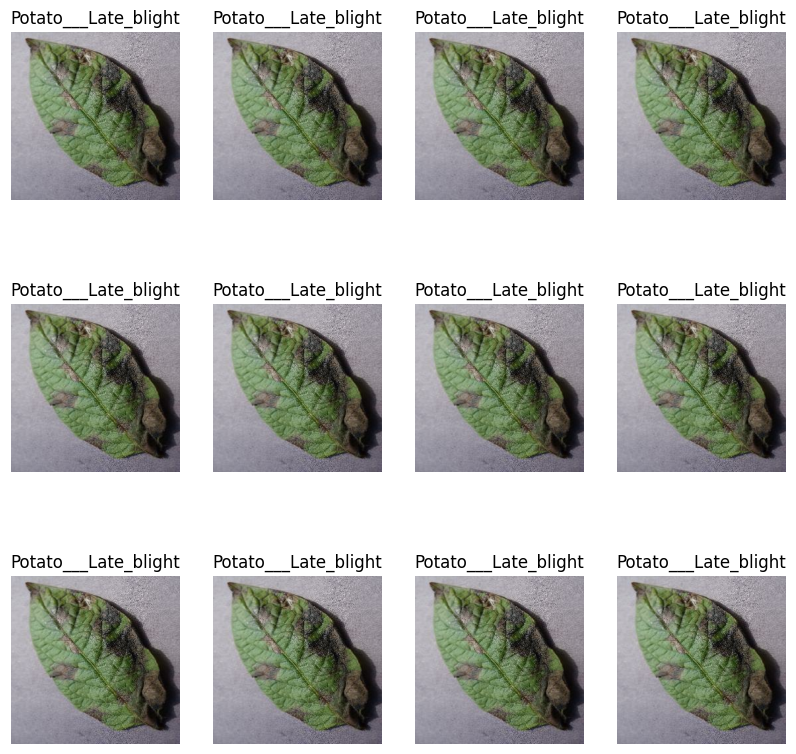

In [7]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax =  plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")
    #rgb, channels, size

In [8]:
len(dataset)

68

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    # Ensure that the sum of the train, validation, and test splits equals 1 
    assert (train_split + test_split + val_split) == 1
    
    # Determine the total size of the dataset
    ds_size = len(ds)
    
    # Shuffle the dataset if specified (default is True) to randomize the order of data samples.
    ds = ds.shuffle(shuffle_size, seed=12)
    
    # Calculate the number of samples for the training set based on the train_split ratio
    train_size = int(train_split * ds_size)
    
    # Calculate the number of samples for the validation set based on the val_split ratio
    val_size = int(val_split * ds_size)
    
    # Take the first `train_size` samples for the training dataset
    train_ds = ds.take(train_size)    
    
    # Skip the first `train_size` samples and take the next `val_size` samples for the validation dataset
    val_ds = ds.skip(train_size).take(val_size)
  
    test_ds = ds.skip(train_size).skip(val_size)
    
    # Return the three datasets: training, validation, and test
    return train_ds, val_ds, test_ds


In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

## Cache Dataset


In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building model

In [21]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential

resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])


# Data Augmentation

In [22]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [23]:
#data aug to train data set

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training = True), y)
).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape            ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)       │             0 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)      │           896 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)      │             0 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)      │        18,496 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)        │             0 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)        │        36,928 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)        │             0 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)        │        36,928 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)        │             0 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)        │        36,928 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)          │             0 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)          │        36,928 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)          │             0 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)               │             0 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)                │        16,448 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                 │           195 │
└─────────────────────────────────┴─────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1,
        epochs=50,
    )


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.4861 - loss: 0.9330 - val_accuracy: 0.6146 - val_loss: 0.7417
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7135 - loss: 0.6392 - val_accuracy: 0.7500 - val_loss: 0.6126
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8559 - loss: 0.3641 - val_accuracy: 0.8646 - val_loss: 0.3283
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 821ms/step - accuracy: 0.8470 - loss: 0.3246 - val_accuracy: 0.9115 - val_loss: 0.2419
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 685ms/step - accuracy: 0.9241 - loss: 0.2078 - val_accuracy: 0.9271 - val_loss: 0.1673
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 676ms/step - accuracy: 0.9360 - loss: 0.1688 - val_accuracy: 0.9115 - val_loss: 0.2606
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 676ms/step - accuracy: 0.9350 - loss: 0.1625 - val_accuracy: 0.9323 - val_loss: 0.2397
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 634ms/step - accuracy: 0.9538 - loss: 0.1112 - val_accuracy: 0.9

In [30]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.9298 - loss: 0.2288


In [31]:
scores

[0.23059172928333282, 0.9296875]

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']



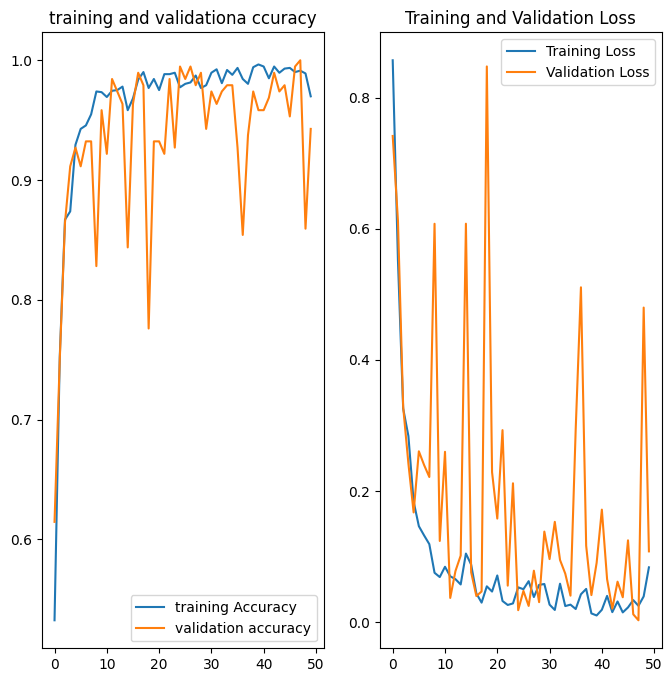

In [47]:
plt.figure(figsize= (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = "training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "validation accuracy")
plt.legend(loc = "lower right")
plt.title("training and validationa ccuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
predicted label: Potato___Early_blight


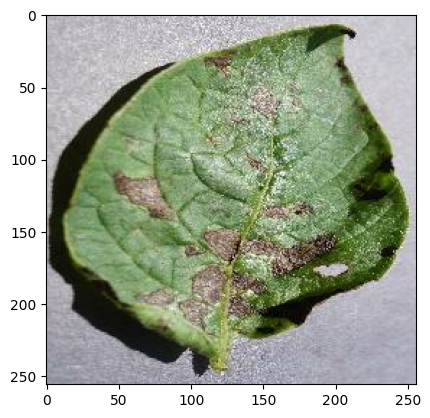

In [46]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [48]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


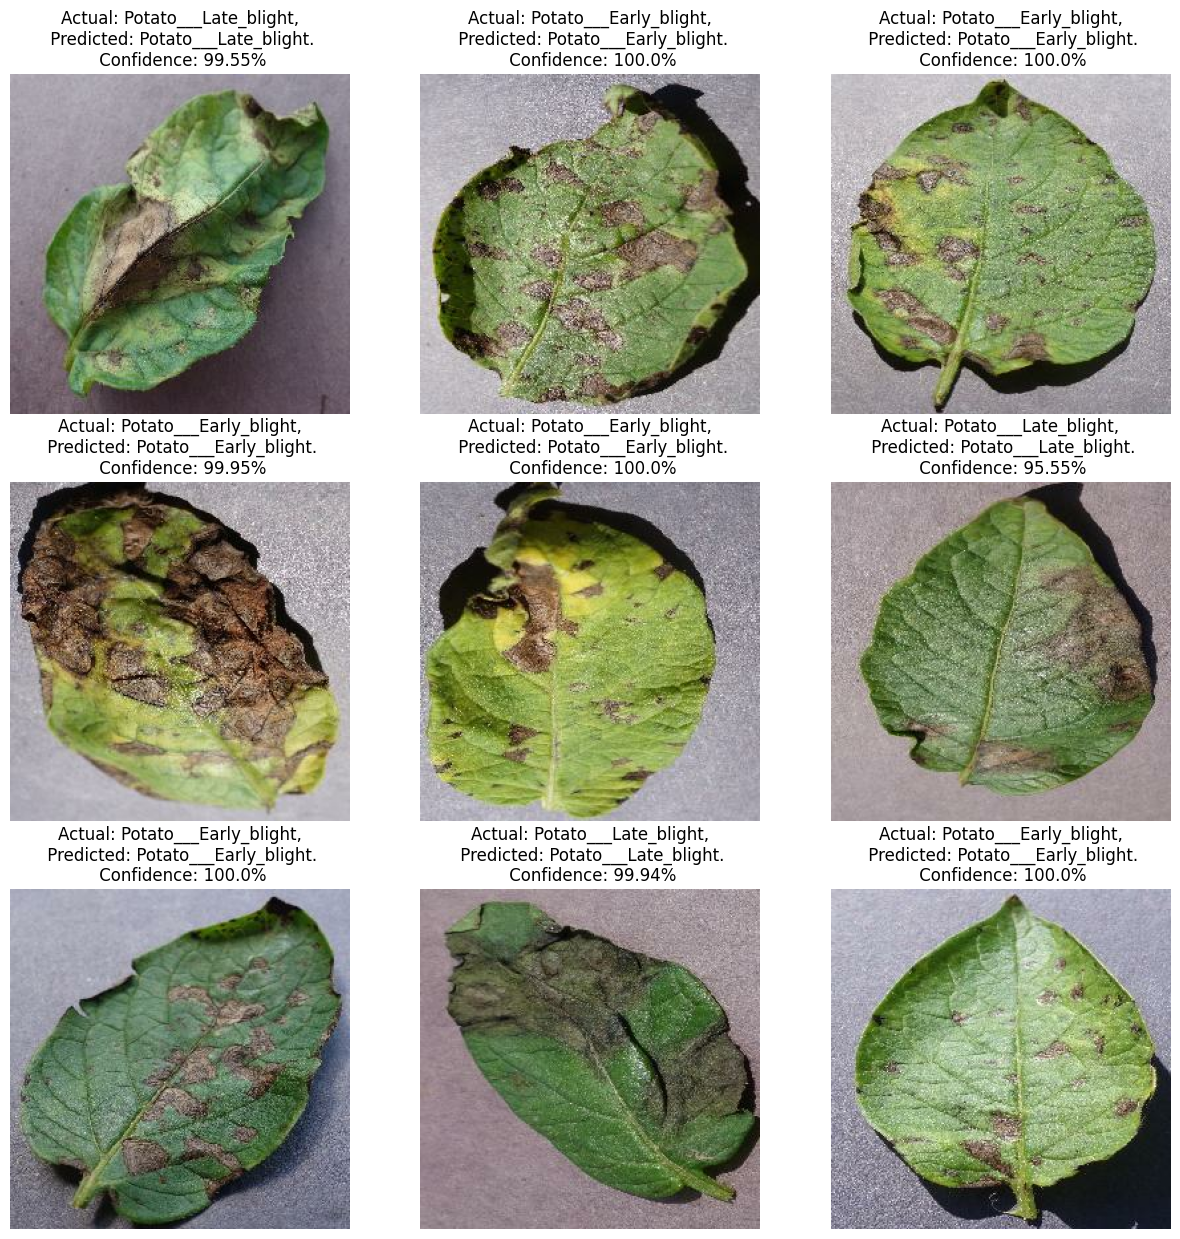

In [49]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [57]:
import os

# Calculate the next model version number
model_version = max([int(i) for i in os.listdir("../models") if i.isdigit()] + [0]) + 1

# Save the model with the appropriate extension
model.save(f"../models/{model_version}.keras")
